<a href="https://colab.research.google.com/github/cykie/TestGit/blob/master/SIADS642.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1: Feed-forward Neural Networks

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(0)
n = 10000
x = np.linspace(0, 20, n)  # x is drawn from a fixed range
y = x ** 3 / 20 - x ** 2 - x + 10 * np.random.randn(n)

# Create the training and testing sets and their targets
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

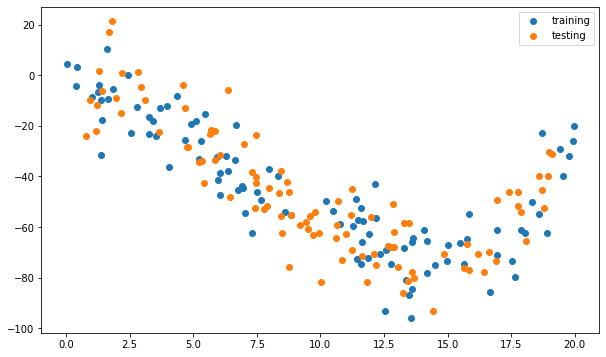

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(X_train[:100], y_train[:100], label="training")
ax.scatter(X_test[:100], y_test[:100], label="testing")
ax.legend()
del fig, ax

In [ ]:
nn.Module?

In [ ]:
import torch
import torch.nn as nn

class DNNRegressor(nn.Module):

    act_fns = {"relu": nn.ReLU(), "sigmoid": nn.Sigmoid(), "tanh": nn.Tanh()}

    def __init__(self, in_dim, out_dim, hid_dims, act_fn="relu", dropout_prob=0.1):
        super().__init__()

        if isinstance(hid_dims, int):
            hid_dims = (hid_dims,)

        if not isinstance(hid_dims, tuple):
            raise ValueError("hid_dims must be a tuple. ")

        self.input_fc = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=hid_dims[0] if hid_dims else out_dim), 
            DNNRegressor.act_fns[act_fn],
            nn.Dropout(dropout_prob)
        )
        
        self.hid_fc = nn.ModuleList()
        for index in range(len(hid_dims) - 1):
            self.hid_fc.append(
                nn.Sequential(
                    nn.Linear(in_features=hid_dims[index], out_features=hid_dims[index + 1]), 
                    DNNRegressor.act_fns[act_fn],
                    nn.Dropout(dropout_prob)
                )
            )
        self.hid_fc = nn.Sequential(*self.hid_fc)

        self.output_fc = nn.Linear(in_features=hid_dims[-1], out_features=out_dim)

    def forward(self, x): # mini-batch (N, D)

        for _, layer in self.named_children():
            x = layer(x)
        return x

        # input_fc_out = self.input_fc(x)

        # for layer in self.hid_fc:
        #     input_fc_out = layer(input_fc_out)

        # # hid_fc_out = self.hid_fc(input_fc_out)

        # hid_fc_out = input_fc_out
        # output_fc_out = self.output_fc(hid_fc_out)
        # return output_fc_out

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch
import math

# https://scikit-learn.org/stable/developers/develop.html

class NeuralRegressor(BaseEstimator):

    loss_fns = {"mse": nn.MSELoss(), "mae": nn.L1Loss()}

    def __init__(self, hid_dims=(100,), act_fn="relu", dropout_prob=0.1, 
                 batch_size=64, lr=1e-3, num_epochs=5, loss_fn="mse", random_state=None):
        self.hid_dims = hid_dims
        self.act_fn = act_fn
        self.dropout_prob = dropout_prob
        self.batch_size = batch_size
        self.lr = lr
        self.num_epochs = num_epochs
        self.loss_fn = NeuralRegressor.loss_fns[loss_fn]
        self.random_state = random_state
        # self._model = None

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        y = y.reshape(X.shape[0], -1)

        in_dim, out_dim = X.shape[-1], y.shape[-1]

        # set random state
        if self.random_state is not None:
            torch.manual_seed(self.random_state)

        # convert np.ndarray to torch.tensor
        X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()

        # wrap data in a dataloader
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)
        
        # device-agnostic; works with both cpu and cuda
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # create the DL model, move it to the correct device and set it to training mode
        self.model_ = DNNRegressor(in_dim, out_dim, self.hid_dims, self.act_fn, self.dropout_prob).to(device).train()

        # only create optimiser when model is on the correct device
        optimiser = optim.Adam(self.model_.parameters(), lr=self.lr)

        for epoch in range(self.num_epochs):
            epoch_loss = 0.0
            for inputs, labels in dataloader:
                # move data to the correct device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # make preds and compute loss
                outputs = self.model_(inputs)
                loss = self.loss_fn(outputs, labels) # mean loss for the current mini-batch
                
                # backprop
                optimiser.zero_grad() # important: clear existing grad
                loss.backward()

                # update weights
                optimiser.step()

                # optional: record loss
                epoch_loss += loss.item() * len(inputs)
            
            epoch_loss /= X.shape[0] # mean loss for current epoch
            if isinstance(self.loss_fn, nn.MSELoss):
                epoch_loss = math.sqrt(epoch_loss)
            print(f"Epoch {epoch}: Avg Train Loss = {epoch_loss}")

        # self.is_fitted_ = True
        # `fit` should always return `self`
        return self

    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples, n_outputs)
            The predicted target values (class labels in classification, real numbers in
            regression).
        """
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'model_')

        X = torch.from_numpy(X).float()
        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, pin_memory=True)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # move the model to the correct device and set it to evaluation mode
        self._model = self.model_.to(device).eval()

        all_outputs = []
        with torch.no_grad(): # ask Pytorch not to record grad - save memory
            for inputs, *_ in dataloader:
                inputs = inputs.to(device)
                outputs = self.model_(inputs)
                all_outputs.append(outputs)
        
        all_outputs = torch.cat(all_outputs, dim=0)
        return all_outputs

    def score(self, X, y):
        """A reference implementation of a scoring function.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The test input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        loss : float
            Returns RMSE if self.loss_fn == "mse". Returns MAE if self.loss_fn == "mae".
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        y = y.reshape(X.shape[0], -1)
        check_is_fitted(self, 'model_')

        X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, pin_memory=True)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # move the model to the correct device and set it to evaluation mode
        self._model = self.model_.to(device).eval()

        total_loss = 0.0
        with torch.no_grad(): # ask Pytorch not to record grad - save memory
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model_(inputs)
                loss = self.loss_fn(outputs, labels)
                total_loss += loss.item() * len(inputs)
        
        total_loss /= X.shape[0]
        if isinstance(self.loss_fn, nn.MSELoss):
            total_loss = math.sqrt(total_loss)
        return total_loss

    # def get_params(self, deep=True):
    #     # suppose this estimator has parameters "alpha" and "recursive"
    #     return {"alpha": self.alpha, "recursive": self.recursive}

    # def set_params(self, **parameters):
    #     for parameter, value in parameters.items():
    #         setattr(self, parameter, value)
    #     return self

In [ ]:
# from sklearn.utils.estimator_checks import check_estimator

neural_reg = NeuralRegressor(batch_size=32, num_epochs=50, random_state=42)
neural_reg.fit(X_train.reshape(-1, 1), y_train)
# check_estimator(neural_reg)

Epoch 0: Avg Train Loss = 26.080078611820998
Epoch 1: Avg Train Loss = 20.52680294542129
Epoch 2: Avg Train Loss = 20.351772379555985
Epoch 3: Avg Train Loss = 20.200802521630266
Epoch 4: Avg Train Loss = 19.97837367783469
Epoch 5: Avg Train Loss = 19.72365430151152
Epoch 6: Avg Train Loss = 19.418695655231865
Epoch 7: Avg Train Loss = 19.15720922736032
Epoch 8: Avg Train Loss = 18.841268669980828
Epoch 9: Avg Train Loss = 18.533543020987846
Epoch 10: Avg Train Loss = 18.284965011595194
Epoch 11: Avg Train Loss = 17.901605208555146
Epoch 12: Avg Train Loss = 17.58753281718909
Epoch 13: Avg Train Loss = 17.252085512329796
Epoch 14: Avg Train Loss = 16.935640717301897
Epoch 15: Avg Train Loss = 16.648237104808324
Epoch 16: Avg Train Loss = 16.313468702778586
Epoch 17: Avg Train Loss = 16.103811913776717
Epoch 18: Avg Train Loss = 15.756470847487021
Epoch 19: Avg Train Loss = 15.504245026270562
Epoch 20: Avg Train Loss = 15.310580159197036
Epoch 21: Avg Train Loss = 15.173078665671692
Epo

NeuralRegressor(act_fn='relu', batch_size=32, dropout_prob=0.1, hid_dims=(100,),
                loss_fn=MSELoss(), lr=0.001, num_epochs=50, random_state=42)

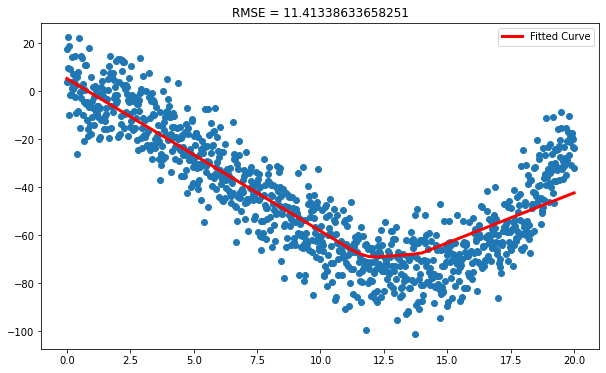

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

np.random.seed(0)
x = np.linspace(0, 20, 1000)  # x is drawn from a fixed range
y = x ** 3 / 20 - x ** 2 - x + 10 * np.random.randn(1000)

ax.scatter(x, y)

y_pred = neural_reg.predict(x.reshape(-1, 1)).cpu().numpy().flatten()
# print(y_pred.flatten().shape)
ax.plot(x, y_pred, color="r", linewidth=3, label="Fitted Curve")
rmse = np.sqrt(np.mean((y - y_pred) ** 2))
ax.set_title(f"RMSE = {rmse}")
ax.legend()

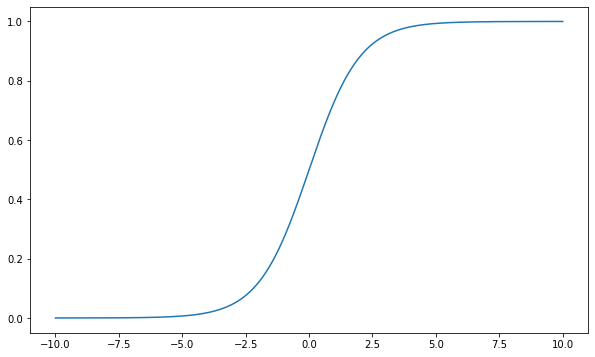

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.linspace(-10, 10, 500)
y = 1 / (1 + np.exp(-x))
ax.plot(x, y)

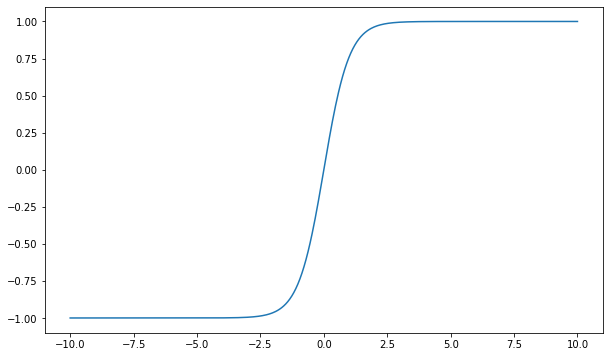

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.linspace(-10, 10, 500)
y = np.tanh(x)
ax.plot(x, y)

In [ ]:
neural_reg.score(x.reshape(-1, 1), y)

35.97700983324974

In [ ]:
# from sklearn.model_selection import GridSearchCV

# clf = GridSearchCV(NeuralRegressor(), {"batch_size":(32, 64, 128)}, safe=False)
# clf.fit(X_train.reshape(-1, 1), y_train)

# Week 2: Convolutional Neural Networks

# New Section

In [ ]:
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2021-03-16 02:32:00--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.33.64, 99.86.33.48, 99.86.33.56, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.33.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   151MB/s    in 0.3s    

2021-03-16 02:32:00 (151 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
! unzip -qq hymenoptera_data.zip

In [ ]:
# Author: Sasank Chilamkurthy: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

import torch
torch.manual_seed(0)

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
batch_size = 4
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == "train"), num_workers=2, pin_memory=True) 
                for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_sizes

{'train': 244, 'val': 153}

In [ ]:
image, label = next(iter(dataloaders["train"]))
image.size()

torch.Size([4, 3, 224, 224])

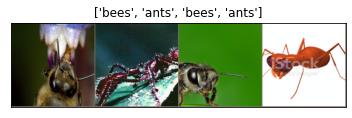

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # grad calculation
                        optimizer.step() # optimisation step - gradient descent

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# https://arxiv.org/abs/1312.6034

def visualize_model(model, num_images=4):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    was_training = model.training
    model = model.to(device).eval()
    images_so_far = 0
    # fig = plt.figure()
    fig, axes = plt.subplots(num_images, 4, figsize=(num_images * 3, 4 * 3), squeeze=False, 
                             gridspec_kw={"wspace": 0, "hspace": 0}, subplot_kw={"aspect": "equal"})
    axes[0, 0].set_title("Original Image")
    axes[0, 1].set_title("Gradient Activation on R")
    axes[0, 2].set_title("Gradient Activation on G")
    axes[0, 3].set_title("Gradient Activation on B")

    for i, (inputs, labels) in enumerate(dataloaders['val']):

        inputs = inputs.to(device).requires_grad_(True)

        outputs = model(inputs)
        max_inds = torch.argmax(outputs, dim=-1)
        input_grads = torch.autograd.grad(outputs[:, max_inds].sum(), inputs)[0]


        inputs = inputs.detach().cpu().numpy().transpose((0, 2, 3, 1)) # (N, H, W, C)
        inputs = np.clip(std * inputs + mean, 0, 1)

        input_grads = np.abs(input_grads.detach().cpu().numpy()) # only magnitude matters
        grad_min = np.amin(input_grads, axis=(-2, -1), keepdims=True)
        grad_max = np.amax(input_grads, axis=(-2, -1), keepdims=True)
        input_grads = np.transpose((input_grads - grad_min) / (grad_max - grad_min), (0, 2, 3, 1)) # (N, H, W, C)

        for j in range(batch_size):
            images_so_far += 1
            axes[j + i * batch_size, 0].imshow(inputs[j])
            axes[j + i * batch_size, 0].set_xticks([])
            axes[j + i * batch_size, 0].set_yticks([])
            axes[j + i * batch_size, 0].set_aspect("equal")

            for c in range(3):
                axes[j + i * batch_size, c + 1].imshow(input_grads[j, :, :, c])
                axes[j + i * batch_size, c + 1].set_xticks([])
                axes[j + i * batch_size, c + 1].set_yticks([])
                axes[j + i * batch_size, c + 1].set_aspect("equal")

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft

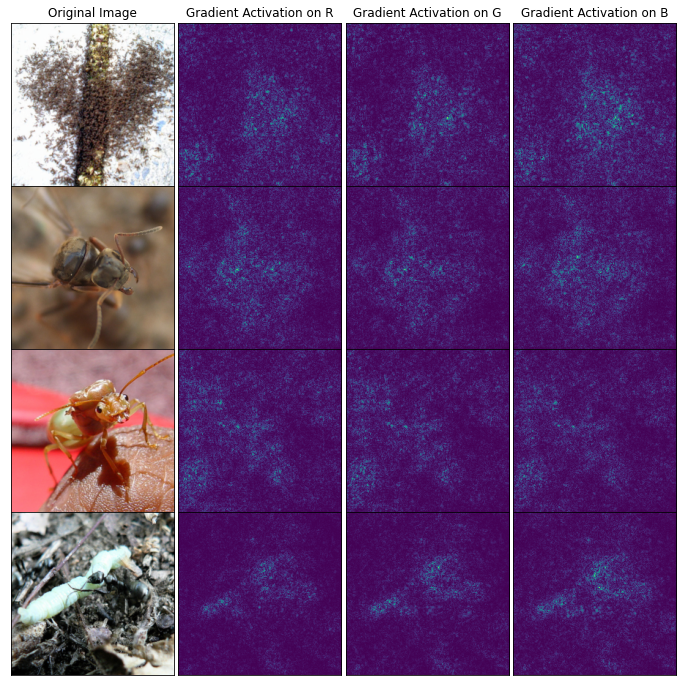

In [ ]:
visualize_model(model_ft, 4)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

In [ ]:
from torchvision.models import vgg16_bn

model = vgg16_bn(pretrained=False)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

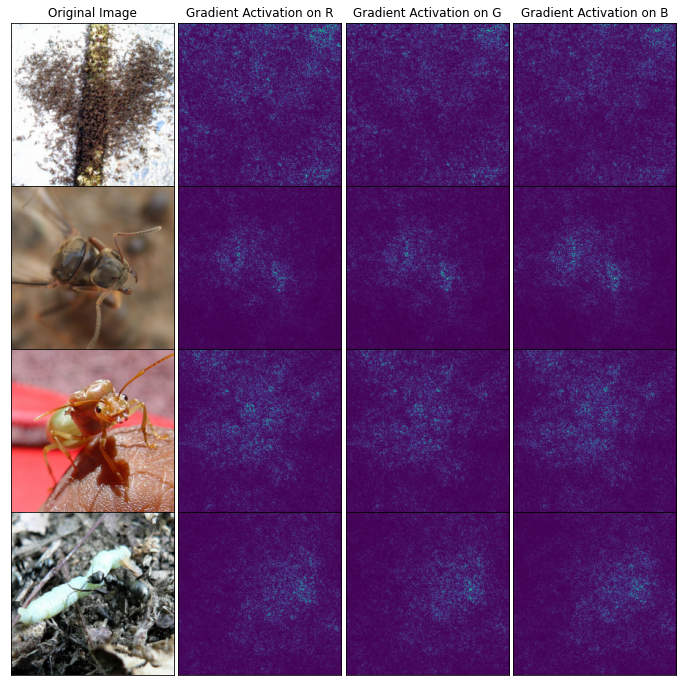

In [ ]:
visualize_model(model_ft, 4)

In [ ]:
model_ft.layer1[0].conv1.weight.size()

for name, layer in model_ft.named_modules():
    if isinstance(layer, nn.Conv2d):
        print(name, layer.weight.size())

conv1 torch.Size([64, 3, 7, 7])
layer1.0.conv1 torch.Size([64, 64, 3, 3])
layer1.0.conv2 torch.Size([64, 64, 3, 3])
layer1.1.conv1 torch.Size([64, 64, 3, 3])
layer1.1.conv2 torch.Size([64, 64, 3, 3])
layer2.0.conv1 torch.Size([128, 64, 3, 3])
layer2.0.conv2 torch.Size([128, 128, 3, 3])
layer2.0.downsample.0 torch.Size([128, 64, 1, 1])
layer2.1.conv1 torch.Size([128, 128, 3, 3])
layer2.1.conv2 torch.Size([128, 128, 3, 3])
layer3.0.conv1 torch.Size([256, 128, 3, 3])
layer3.0.conv2 torch.Size([256, 256, 3, 3])
layer3.0.downsample.0 torch.Size([256, 128, 1, 1])
layer3.1.conv1 torch.Size([256, 256, 3, 3])
layer3.1.conv2 torch.Size([256, 256, 3, 3])
layer4.0.conv1 torch.Size([512, 256, 3, 3])
layer4.0.conv2 torch.Size([512, 512, 3, 3])
layer4.0.downsample.0 torch.Size([512, 256, 1, 1])
layer4.1.conv1 torch.Size([512, 512, 3, 3])
layer4.1.conv2 torch.Size([512, 512, 3, 3])


In [ ]:
def visualize_activation(layer_out, img_idx=0):
    plt.figure(figsize=(24, 24))
    plt.xticks([])
    plt.yticks([])

    layer_out = torch.abs(layer_out)
    layer_out_min = torch.amin(layer_out, dim=(-2, -1), keepdim=True)
    layer_out_max = torch.amax(layer_out, dim=(-2, -1), keepdim=True)
    layer_out = (layer_out - layer_out_min) / (layer_out_max - layer_out_min)
    layer_out_grid = torchvision.utils.make_grid(layer_out[img_idx].unsqueeze(dim=1), nrow=16)
    layer_out_grid = layer_out_grid.detach().cpu().numpy().transpose((1, 2, 0))
    plt.imshow(layer_out_grid)

def visualize_layer_activation(model, img_idx):
    model = model.to(device).eval()

    images, labels = next(iter(dataloaders["val"]))

    out = torchvision.utils.make_grid(images)
    imshow(out, title=[class_names[x] for x in labels])
    
    with torch.no_grad():
        images = images.to(device)

        pre_layer1 = nn.Sequential(model.conv1, model.bn1, model.relu, model.maxpool)
        layer1_out = model.layer1(pre_layer1(images))
        visualize_activation(layer1_out.clone().detach(), img_idx)

        layer2_out = model.layer2(layer1_out)
        visualize_activation(layer2_out.clone().detach(), img_idx)
        
        layer3_out = model.layer3(layer2_out)
        visualize_activation(layer3_out.clone().detach(), img_idx)

        layer4_out = model.layer4(layer3_out)
        visualize_activation(layer4_out.clone().detach(), img_idx)  

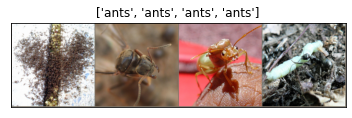

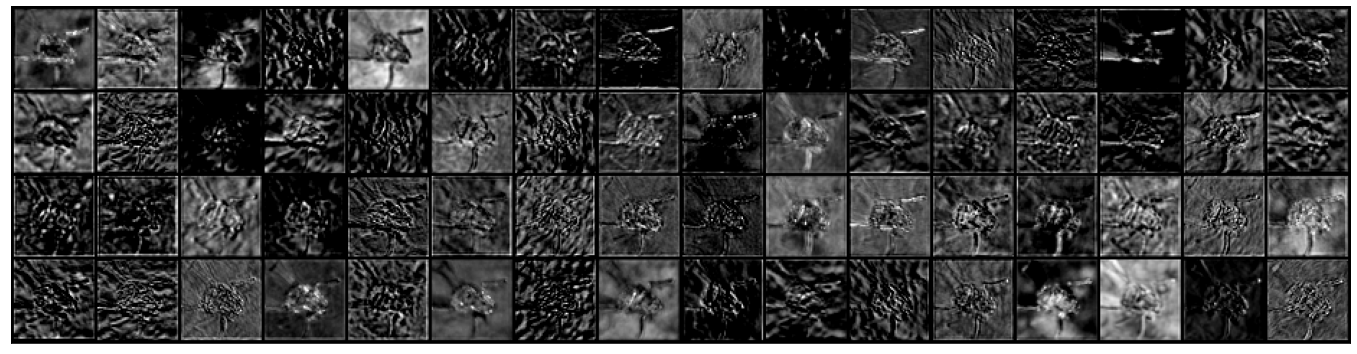

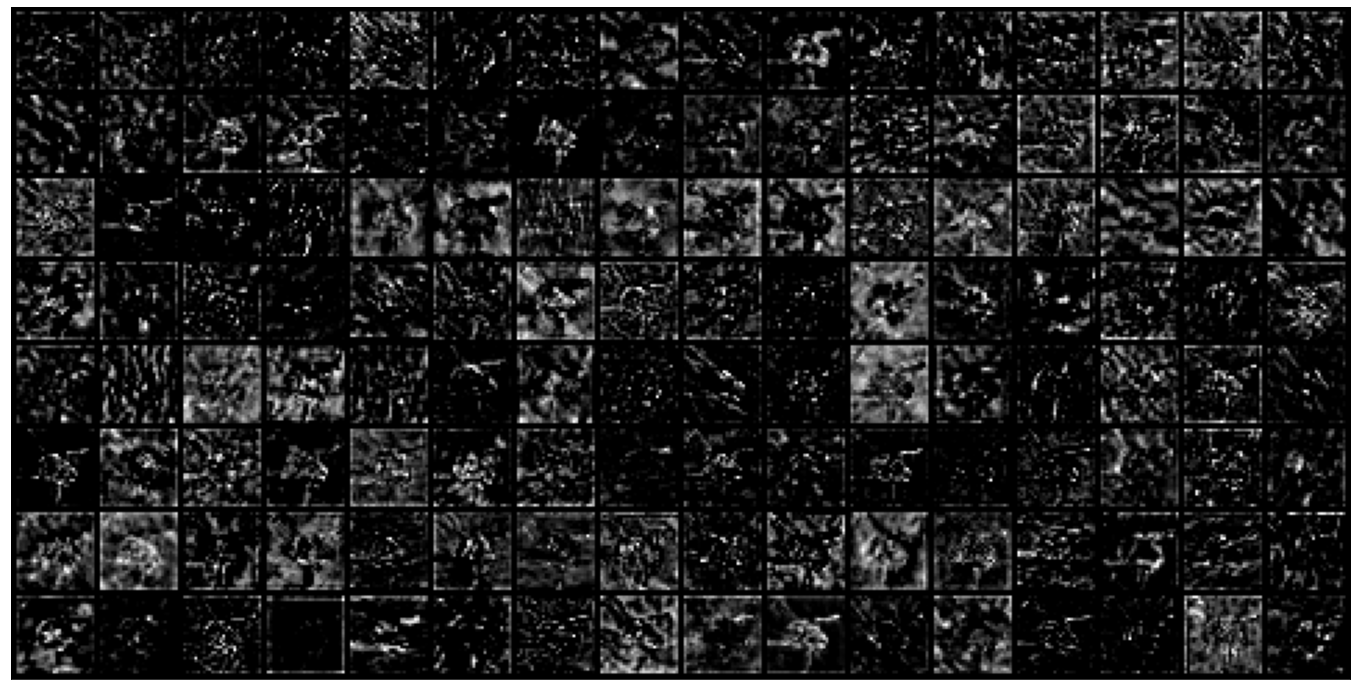

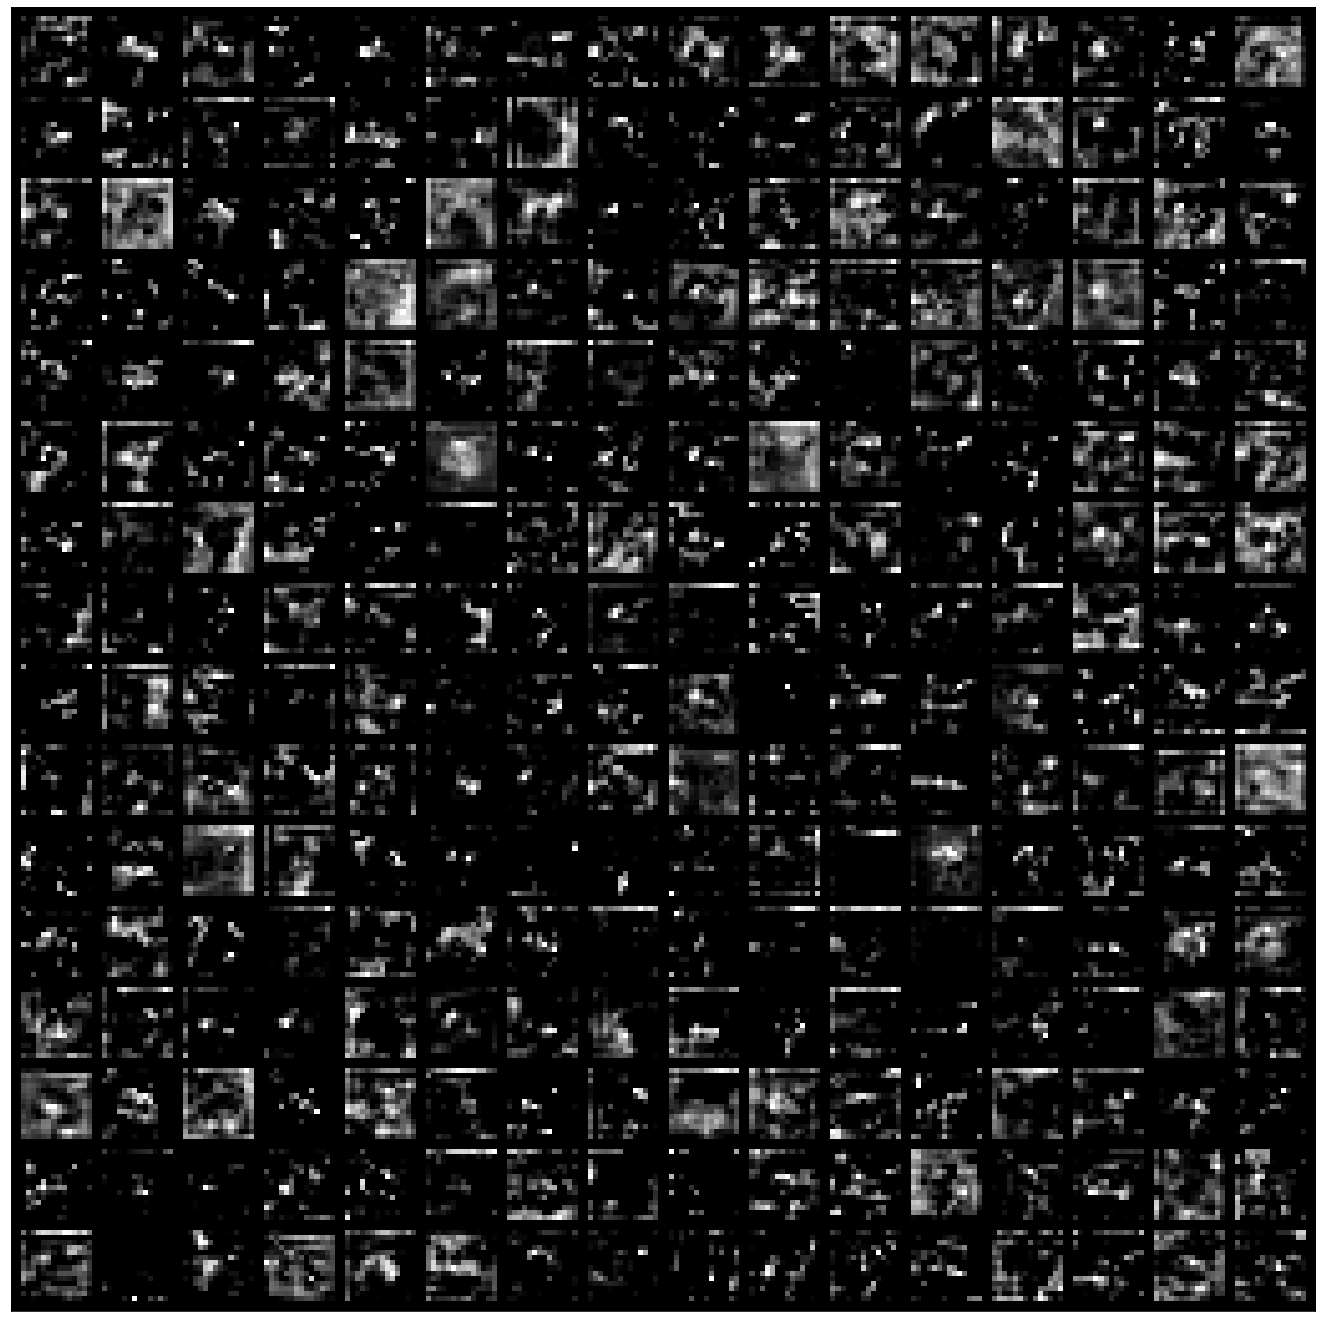

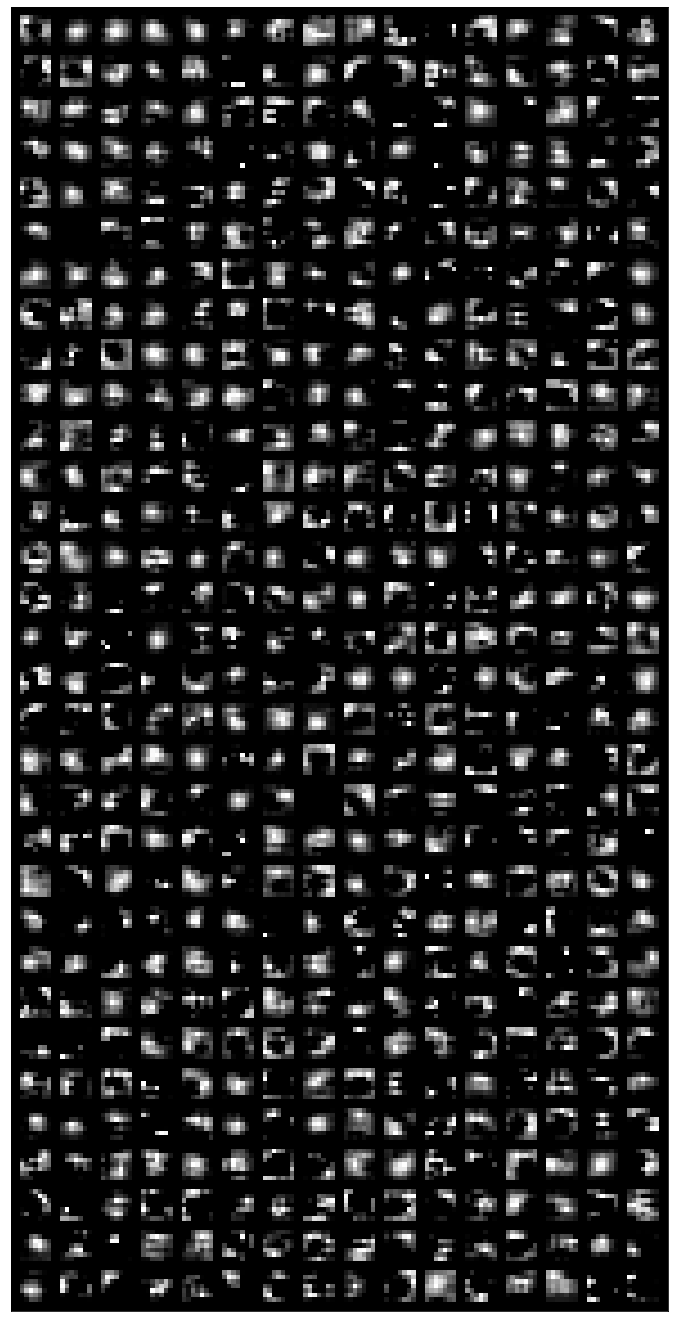

In [ ]:
visualize_layer_activation(model_ft, 1)

# Week 4: Minimum viable pipeline in PyTorch

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import Dataset

class CalHousingDataset(Dataset):
    def __init__(self, dataset):
        super().__init__()

        X, y = fetch_california_housing(return_X_y=True)
        X = StandardScaler().fit_transform(X)
         
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

        if dataset == "train":
            self.dataset = torch.from_numpy(X_train).float()
            self.labels = torch.from_numpy(y_train).float()
        elif dataset == "val":
            self.dataset = torch.from_numpy(X_val).float()
            self.labels = torch.from_numpy(y_val).float()
        elif dataset == "test":
            self.dataset = torch.from_numpy(X_test).float()
            self.labels = torch.from_numpy(y_test).float()
        else:
            raise ValueError("Unknown dataset!")
        
    def __getitem__(self, index):
        return self.dataset[index], self.labels[index]

    def __len__(self):
        return len(self.dataset)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128
# cal_housing_dataset = CalHousingDataset("val")
# # cal_housing_dataset[:10]

# cal_housing_dataloader = DataLoader(cal_housing_dataset, batch_size=batch_size, shuffle=True)
# data, label = next(iter(cal_housing_dataloader))
# label.size()

dataloaders = {
    "train": DataLoader(CalHousingDataset("train"), batch_size=batch_size, shuffle=True), 
    "val": DataLoader(CalHousingDataset("val"), batch_size=batch_size, shuffle=False), 
    "test": DataLoader(CalHousingDataset("test"), batch_size=batch_size, shuffle=False), 
}

In [ ]:
inputs, labels = next(iter(dataloaders["train"]))
inputs.size(), labels.size()

(torch.Size([128, 8]), torch.Size([128]))

In [ ]:
import torch.nn as nn

class NeuralRegressor(nn.Module):
    def __init__(self, in_dim, hid_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=hid_dim), 
            nn.ReLU(), 
            nn.Linear(in_features=hid_dim, out_features=1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
import torch.optim as optim

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_dim, hid_dim = 8, 32

model = NeuralRegressor(in_dim, hid_dim).to(device)
optimiser = optim.SGD(model.parameters(), lr=1e-2)

In [ ]:
# If you want to train a NEW model, remember to run the cell above
from collections import defaultdict

num_epochs = 50
loss_fn = nn.MSELoss()

epoch_losses = defaultdict(list)

for epoch in range(num_epochs):

    for phase in ["train", "val"]:

        epoch_loss, total = 0.0, 0.0

        if phase == "train":
            model.train()
        else:
            model.eval()
        
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(dim=-1)

            with torch.set_grad_enabled(phase == "train"): # saves memory
                outputs = model(inputs) # forward step
                loss = loss_fn(outputs, labels) # compute loss using outputs and labels

            if phase == "train":
                optimiser.zero_grad()
                loss.backward() # back-prop step; computes the gradients w.r.t weights
                optimiser.step() # optimisation step; update weights

            epoch_loss += loss.item() * inputs.size(0)
            total += inputs.size(0)
        
        epoch_losses[phase].append(epoch_loss / total)

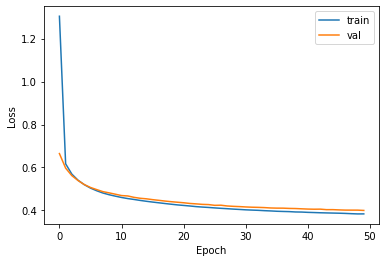

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses["train"], label="train")
plt.plot(epoch_losses["val"], label="val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()